# Denoising AutoEncoder on CIFAR10 Dataset

# Tasks

Try using a denoising autoencoder to pretrain an image classifier.
You can use MNIST (the simplest option), or a more compleximage dataset such as CIFAR10 if you want a bigger challenge.
Regardless of the dataset you’re using, follow these steps:

1. Split the dataset into a training set and a test set. Train a
deep denoising autoencoder on the full training set.

2. Check that the images are fairly well reconstructed.
Visualize the images that most activate each neuron in
the coding layer.

3. Build a classification DNN, reusing the lower layers of
the autoencoder. Train it using only 500 images from the
training set. Does it perform better with or without
pretraining?

# Importing Libraries

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Helper Functions

In [2]:
class_names = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship",
               "truck"]

def idx_to_class_name(idx):
    return class_names[idx]

# Task 1.1 -  Dataset Loading

In [5]:
(X_train, y_train), (X_test, y_test) = keras.datasets.cifar10.load_data()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 11s 0us/step


In [6]:
X_train = X_train / 255.0
X_test = X_test / 255.0

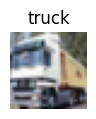

In [7]:
def plot_sample(img, label):
    plt.figure(figsize=(10,1))
    plt.imshow(img)
    plt.title(label)
    plt.axis('off')

plot_sample(X_train[1], idx_to_class_name(y_train[1][0]))

# Task 1.2 - Model Building

In [8]:
keras.backend.clear_session()

In [9]:
denoising_encoder = keras.models.Sequential([
    keras.layers.Input(shape=(32, 32, 3)),
    keras.layers.GaussianNoise(0.1, seed=42),
    keras.layers.Conv2D(64, kernel_size=3, padding="same", activation="relu"),
    keras.layers.MaxPool2D(),
    keras.layers.Conv2D(32, kernel_size=3, padding="same", activation="relu"),
    keras.layers.MaxPool2D(),
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation="relu"),
])

In [10]:
denoising_encoder.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gaussian_noise (GaussianNoise)       │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 32, 32, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 16, 16, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 8, 8, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       1,049,088 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,069,344 (4.08 MB)

 Trainable params: 1,069,344 (4.08 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
denoising_decoder = keras.models.Sequential([
    keras.layers.Input(shape=[512]), # Matches Encoders Dense output
    keras.layers.Dense(8*8*32, activation="relu"), # Prepare for reshaping (32 channel, 8*8 due to MaxPool 2D)
    keras.layers.Reshape([8,8,32]), # Reshape to match last conv2D's output shape before flattening

    # Replace MaxPool2D with UpSampling2D
    keras.layers.UpSampling2D(2),  # 8*8 -> 16*16
    keras.layers.Conv2D(32, kernel_size=3, padding="same", activation="relu"),

    keras.layers.UpSampling2D(2), #16*16 -> 32*32
    keras.layers.Conv2D(64, kernel_size=3, padding="same", activation="relu"),

    # Final layer to reconstruct original image
    keras.layers.Conv2D(3, kernel_size=3, padding="same", activation="sigmoid")
])

In [12]:
denoising_decoder.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                      │ (None, 2048)                │       1,050,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 8, 8, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d (UpSampling2D)         │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 16, 16, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_1 (UpSampling2D)       │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 32, 32, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 32, 32, 3)           │           1,731 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,080,099 (4.12 MB)

 Trainable params: 1,080,099 (4.12 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
denoising_ae = keras.models.Sequential([denoising_encoder, denoising_decoder])
denoising_ae.compile(loss="binary_crossentropy", optimizer="nadam")

In [14]:
h = denoising_ae.fit(X_train, X_train, epochs=20, validation_data=(X_test, X_test))

Epoch 1/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 17s 7ms/step - loss: 0.5991 - val_loss: 0.5964
Epoch 2/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.5689 - val_loss: 0.5710
Epoch 3/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.5657 - val_loss: 0.5686
Epoch 4/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.5635 - val_loss: 0.5649
Epoch 5/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.5615 - val_loss: 0.5629
Epoch 6/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.5614 - val_loss: 0.5624
Epoch 7/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.5611 - val_loss: 0.5636
Epoch 8/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.5607 - val_loss: 0.5625
Epoch 9/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.5596 - val_loss: 0.5604
Epoch 10/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.5594 - val_loss: 0.5601
Epoch 11/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.5590 - val_loss: 0.5597
Epoch 12/20
1563/1563 ━━━━━━━

In [15]:
denoising_ae.save("trained_model.keras")

# Task 2.1 - Checking the reconstructions

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step


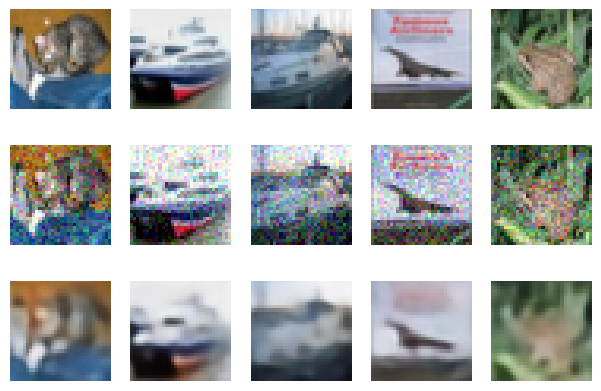

In [16]:
def plot_reconstructions(model, images, n_images=5):
    noisy_images = model.layers[0].layers[0](images[:n_images], training=True)
    reconstructions = model.predict(images[:n_images])
    plt.figure(figsize=(n_images * 1.5, 5))
    for img_index in range(n_images):
        plt.subplot(3, n_images, 1 + img_index)
        plt.imshow(images[img_index])
        plt.axis("off")
        plt.subplot(3, n_images, 1+ n_images + img_index)
        plt.imshow(noisy_images[img_index])
        plt.axis("off")
        plt.subplot(3, n_images, n_images*2 + img_index + 1)
        plt.imshow(reconstructions[img_index])
        plt.axis("off")

plot_reconstructions(denoising_ae, X_test)

In [17]:
def calculate_rmse(model, X_test):

    noisy_images = model.layers[0].layers[0](X_test, training=True)
    reconstructed_images = model.predict(noisy_images)

    mse = np.mean((X_test - reconstructed_images)**2, axis=(1,2,3)) # per image MSE
    rmse = np.sqrt(mse) # per img mse
    print(rmse.shape)
    
    return rmse.mean() # avg across all images

In [18]:
calculate_rmse(denoising_ae, X_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
(10000,)


0.0655479289902393

In [19]:
def calculate_psnr(model, X_test):

    noisy_images = model.layers[0].layers[0](X_test, training=True)
    reconstructed_images = model.predict(noisy_images)

    mse = np.mean((X_test - reconstructed_images)**2, axis=(1,2,3)) # per image MSE
    psnr_per_image = 10 * np.log10((1 ** 2) / mse)

    # psnr avg across whole dataset
    return np.mean(psnr_per_image)

In [20]:
calculate_psnr(denoising_ae, X_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


23.889634350614408

# Task 2.2 - Checking Neurons's activations

In [23]:
feature_representations = denoising_encoder(X_test)
feature_representations.shape

TensorShape([10000, 512])

In [30]:
idxs = tf.math.argmax(feature_representations, axis=0).numpy()

In [57]:
unique_indices, freqs = np.unique(idxs, return_counts=True)
unique_indices.shape, freqs.shape

((148,), (148,))

In [62]:
order = np.argsort(freqs)
freqs_sorted = freqs[order]
unq_idx_sorted = unique_indices[order]

In [64]:
unq_idx_sorted_rev = unq_idx_sorted[::-1]
unq_idx_sorted_rev

array([   0, 2004, 4753, 5460, 4453, 3485, 4421, 8684, 2940, 3444, 3688,
       9599, 6565, 8726, 7835, 4634, 5263, 5416,  925, 6675, 9899, 5447,
       8877, 1947, 9246, 1640, 2617, 4481, 6555, 2679, 1270, 2752, 8756,
       4291, 7352, 7359, 3582, 7399, 7486,  276, 9482, 8666, 3647, 3343,
       9633, 3471, 2089, 2381, 2393, 3442, 2537, 3430, 2633, 3210, 3125,
       2698,  374, 2757, 2795, 2840, 2810, 2031,  558,  574,  678,  741,
        801,  872, 9801,  474, 9292, 9395, 9520, 9535, 9765, 1904, 1051,
       1110, 1150, 1307, 1416, 1469, 1474, 1494, 1615, 1641, 1654,  198,
       1930, 1969, 9601, 5794, 6110, 6232, 6315, 6350, 6410, 6563, 8801,
       6585, 6655, 6814, 6864, 7208, 3782, 7421, 7578, 7612, 7892, 8039,
       8144, 8244, 8338, 8366, 8482, 8562, 8580, 8598, 7384, 3542, 3629,
       3633,  188, 3756, 3828, 3846, 4072, 4107, 4124, 4193, 4285, 4343,
       5780, 4425,   98, 4487, 4532, 4602,   44, 4831, 5115, 9215, 5311,
       9199, 5475, 5551, 5570,  148])

These are the images that most activated the neurons. Let's plot the top 50 images

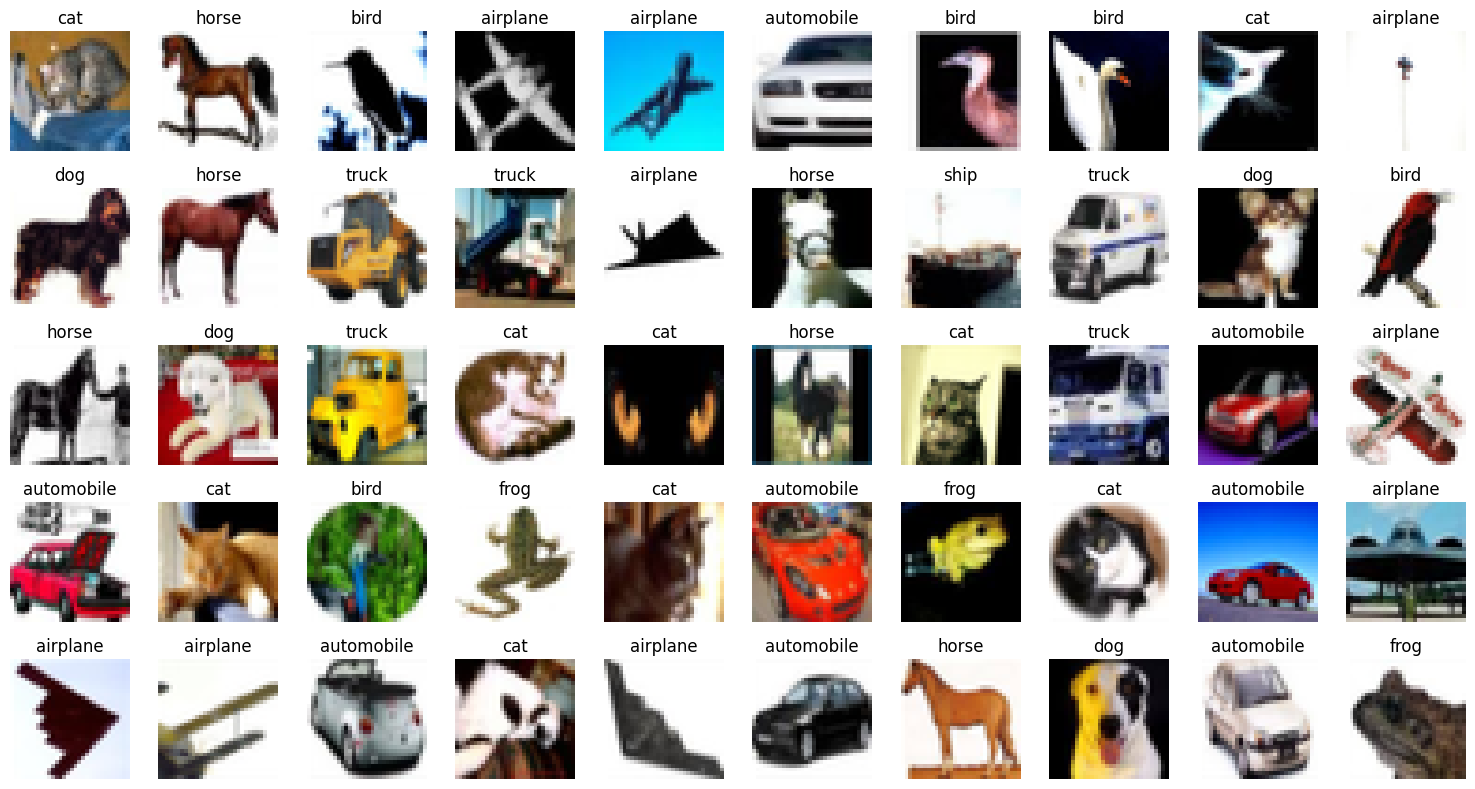

In [86]:
plt.figure(figsize=(15, 8))
plt.subplots_adjust(wspace=0.1, hspace=0.2)
for i in range(50):
    plt.subplot(5, 10, i + 1)
    plt.imshow(X_test[unq_idx_sorted_rev[i]])
    plt.title(idx_to_class_name(y_test[unq_idx_sorted_rev[i]][0]))
    plt.axis('off')

plt.tight_layout()
plt.show()

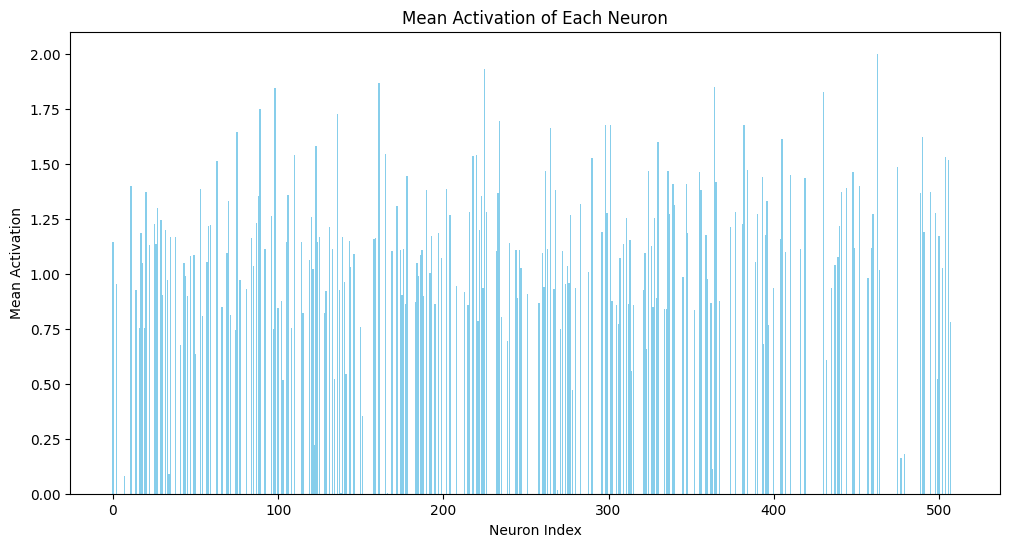

In [88]:
mean_activations = np.mean(feature_representations, axis=0)
plt.figure(figsize=(12, 6))
plt.bar(range(512), mean_activations, color='skyblue')
plt.title('Mean Activation of Each Neuron')
plt.xlabel('Neuron Index')
plt.ylabel('Mean Activation')
plt.show()


In [90]:
features_embedded = TSNE().fit_transform(feature_representations)
features_embedded.shape

(10000, 2)

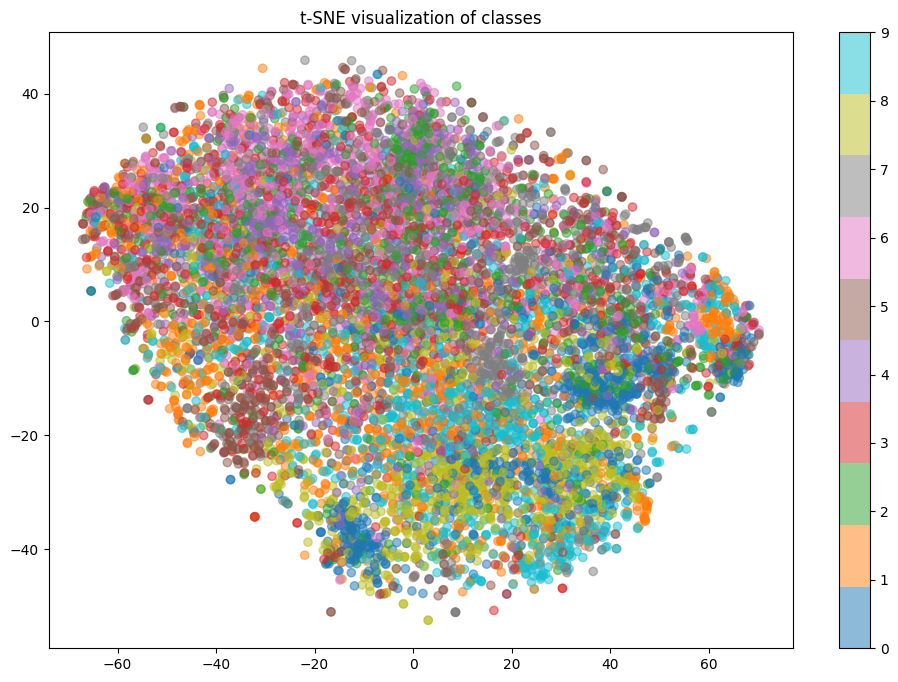

In [95]:
plt.figure(figsize=(12, 8))
scatter = plt.scatter(features_embedded[:, 0], features_embedded[:, 1], 
                     c=y_test, 
                     cmap='tab10',
                     alpha=0.5)
plt.colorbar(scatter)
plt.title('t-SNE visualization of classes')
plt.show()

# Task 3.1 - Classification Model with Pretraining

In [101]:
X_train_subset, y_train_subset = X_train[10000:10500, :, :, :], y_train[10000:10500, :]
X_train_subset.shape, y_train_subset.shape

((500, 32, 32, 3), (500, 1))

In [109]:
for layer in denoising_encoder.layers:
    layer.trainable = False

In [124]:
classification_model = keras.models.Sequential([
    denoising_encoder, 
    keras.layers.Dense(len(class_names), activation="softmax")
])

In [125]:
classification_model.compile(optimizer="nadam", loss="sparse_categorical_crossentropy", metrics=
                             ["accuracy"])

In [126]:
early_stopping = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

h = classification_model.fit(X_train_subset, y_train_subset, epochs=50, validation_split=0.2,
                            callbacks=[early_stopping])

Epoch 1/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 151ms/step - accuracy: 0.1202 - loss: 2.9167 - val_accuracy: 0.1000 - val_loss: 2.5387
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1224 - loss: 2.4786 - val_accuracy: 0.1100 - val_loss: 2.5041
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1512 - loss: 2.3587 - val_accuracy: 0.1000 - val_loss: 2.4375
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1814 - loss: 2.3342 - val_accuracy: 0.0600 - val_loss: 2.4360
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1906 - loss: 2.2778 - val_accuracy: 0.1000 - val_loss: 2.3799
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2140 - loss: 2.1924 - val_accuracy: 0.1200 - val_loss: 2.3596
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2221 - loss: 2.1712 - val_accuracy: 0.1200 - val_loss: 2.3593
Epoch 8/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2605 - loss: 2.1180 - val_accuracy: 0.1500 - val_los

In [136]:
preds = classification_model.predict(X_test[:5])
pred_class = np.argmax(preds, axis=1)
for i in range(len(pred_class)):
    print(f"True= {idx_to_class_name(y_test[i][0])}, Prdicted= {idx_to_class_name(pred_class[i])}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
True= cat, Prdicted= dog
True= ship, Prdicted= ship
True= ship, Prdicted= ship
True= airplane, Prdicted= ship
True= frog, Prdicted= deer


In [144]:
preds = classification_model.predict(X_test)
pred_class = np.argmax(preds, axis=1)

y_test_reshaped = y_test.reshape(-1, )
accuracy = accuracy_score(y_test_reshaped, pred_class)
precision = precision_score(y_test_reshaped, pred_class, average="micro")
recall = recall_score(y_test_reshaped, pred_class, average="micro")
f1 = f1_score(y_test_reshaped, pred_class, average="micro")

print(f"Accuracy = {accuracy:.2f}")
print(f"Precision = {precision:.2f}")
print(f"Recall = {recall:.2f}")
print(f"F1 = {f1:.2f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Accuracy = 0.28
Precision = 0.28
Recall = 0.28
F1 = 0.28


# Task 3.2 - Classification Model without Pretraining

In [145]:
encoder_new = keras.models.Sequential([
    keras.layers.Input(shape=(32, 32, 3)),
    keras.layers.GaussianNoise(0.1, seed=42),
    keras.layers.Conv2D(64, kernel_size=3, padding="same", activation="relu"),
    keras.layers.MaxPool2D(),
    keras.layers.Conv2D(32, kernel_size=3, padding="same", activation="relu"),
    keras.layers.MaxPool2D(),
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation="relu"),
])

In [146]:
classification_model_scratch = keras.models.Sequential([
    encoder_new,
    keras.layers.Dense(len(class_names), activation="softmax")
])

In [147]:
classification_model_scratch.compile(optimizer="nadam", loss="sparse_categorical_crossentropy", 
                                     metrics=["accuracy"])

In [148]:
early_stopping = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

h = classification_model_scratch.fit(X_train_subset, y_train_subset, epochs=100,
                                     validation_split=0.2, callbacks=[early_stopping])

Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 165ms/step - accuracy: 0.0950 - loss: 2.3161 - val_accuracy: 0.1600 - val_loss: 2.3053
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2313 - loss: 2.2033 - val_accuracy: 0.1700 - val_loss: 2.2717
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2380 - loss: 2.0449 - val_accuracy: 0.2300 - val_loss: 2.1840
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3514 - loss: 1.8740 - val_accuracy: 0.2500 - val_loss: 2.1015
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3869 - loss: 1.7615 - val_accuracy: 0.2500 - val_loss: 2.0242
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4913 - loss: 1.5844 - val_accuracy: 0.2600 - val_loss: 2.0314
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5772 - loss: 1.3268 - val_accuracy: 0.2800 - val_loss: 2.0028
Epoch 8/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6058 - loss: 1.2133 - val_accuracy: 0.2800 -

In [149]:
preds = classification_model_scratch.predict(X_test[:5])
pred_class = np.argmax(preds, axis=1)
for i in range(len(pred_class)):
    print(f"True= {idx_to_class_name(y_test[i][0])}, Prdicted= {idx_to_class_name(pred_class[i])}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
True= cat, Prdicted= dog
True= ship, Prdicted= truck
True= ship, Prdicted= ship
True= airplane, Prdicted= ship
True= frog, Prdicted= deer


In [150]:
preds = classification_model_scratch.predict(X_test)
pred_class = np.argmax(preds, axis=1)

y_test_reshaped = y_test.reshape(-1, )
accuracy = accuracy_score(y_test_reshaped, pred_class)
precision = precision_score(y_test_reshaped, pred_class, average="micro")
recall = recall_score(y_test_reshaped, pred_class, average="micro")
f1 = f1_score(y_test_reshaped, pred_class, average="micro")

print(f"Accuracy = {accuracy:.2f}")
print(f"Precision = {precision:.2f}")
print(f"Recall = {recall:.2f}")
print(f"F1 = {f1:.2f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Accuracy = 0.34
Precision = 0.34
Recall = 0.34
F1 = 0.34


# Task 3.3 - Fine Tuning the Pretrained Classification Model

In [151]:
for layer in denoising_encoder.layers:
    layer.trainable=True

In [152]:
classification_model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-5),
                             loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [159]:
h = classification_model.fit(X_train_subset, y_train_subset, epochs=20, validation_split=0.2)

Epoch 1/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5371 - loss: 1.4154 - val_accuracy: 0.2400 - val_loss: 2.1649
Epoch 2/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5207 - loss: 1.4808 - val_accuracy: 0.2500 - val_loss: 2.1616
Epoch 3/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5515 - loss: 1.3847 - val_accuracy: 0.2500 - val_loss: 2.1631
Epoch 4/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5326 - loss: 1.3974 - val_accuracy: 0.2600 - val_loss: 2.1638
Epoch 5/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5194 - loss: 1.4312 - val_accuracy: 0.2500 - val_loss: 2.1664
Epoch 6/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5548 - loss: 1.4108 - val_accuracy: 0.2500 - val_loss: 2.1669
Epoch 7/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5294 - loss: 1.4432 - val_accuracy: 0.2600 - val_loss: 2.1634
Epoch 8/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5444 - loss: 1.4319 - val_accuracy: 0.2600 - val_loss:

In [160]:
preds = classification_model.predict(X_test)
pred_class = np.argmax(preds, axis=1)

y_test_reshaped = y_test.reshape(-1, )
accuracy = accuracy_score(y_test_reshaped, pred_class)
precision = precision_score(y_test_reshaped, pred_class, average="micro")
recall = recall_score(y_test_reshaped, pred_class, average="micro")
f1 = f1_score(y_test_reshaped, pred_class, average="micro")

print(f"Accuracy = {accuracy:.2f}")
print(f"Precision = {precision:.2f}")
print(f"Recall = {recall:.2f}")
print(f"F1 = {f1:.2f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Accuracy = 0.30
Precision = 0.30
Recall = 0.30
F1 = 0.30
